In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

In [2]:
div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteJ4KSU1/div2k-train.tfrecord*...:   0%|   …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteJ4KSU1/div2k-validation.tfrecord*...:   0…

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


In [3]:
train = div2k_data.as_dataset(split="train", as_supervised=True)
train_cache = train.cache()

val = div2k_data.as_dataset(split="validation", as_supervised=True)
val_cache = val.cache()

In [4]:
def flip_left_right(low_res_img, high_res_img):
  rn = tf.random.uniform(shape=(), maxval=1)
  return tf.cond(
      rn < 0.5,
      lambda: (low_res_img, high_res_img),
      lambda: (
          tf.image.flip_left_right(low_res_img),
          tf.image.flip_left_right(high_res_img)
      )
  )

In [5]:
def random_rotate(low_res_img, high_res_img):
  rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
  return tf.image.rot90(low_res_img, rn), tf.image.rot90(high_res_img, rn)

In [6]:
def random_crop(low_res_img, high_res_img, hr_crop_size=96, scale=4):
  low_res_crop_size = hr_crop_size // scale
  low_res_img_shape = tf.shape(low_res_img)[:2]
  low_res_width = tf.random.uniform(
      shape=(), maxval=low_res_img_shape[1] - low_res_crop_size + 1, dtype=tf.int32
  )
  low_res_height = tf.random.uniform(
      shape=(), maxval=low_res_img_shape[0] - low_res_crop_size + 1, dtype=tf.int32
  )
  high_res_width = low_res_width * scale
  high_res_height = low_res_height * scale
  low_res_img_cropped = low_res_img[
      low_res_height : low_res_height + low_res_crop_size,
      low_res_width : low_res_width + low_res_crop_size
  ]
  high_res_img_cropped = high_res_img[
      high_res_height : high_res_height + hr_crop_size,
      high_res_width : high_res_width + hr_crop_size
  ]
  return low_res_img_cropped, high_res_img_cropped

In [7]:
def dataset_object(dataset_cache, training=True):
  ds = dataset_cache
  ds = ds.map(
      lambda low_res, high_res: random_crop(low_res, high_res, scale=4),
      num_parallel_calls=AUTOTUNE
  )
  if training:
    ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
    ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
  ds = ds.batch(4)
  if training:
    ds = ds.repeat()
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [8]:
train_ds = dataset_object(train_cache, training=True)
val_ds = dataset_object(val_cache, training=False)

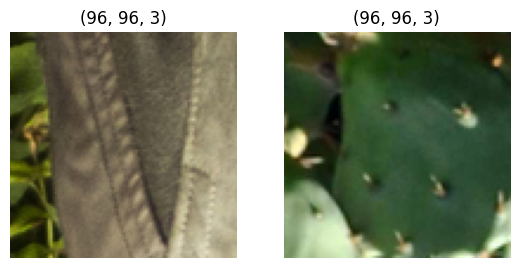

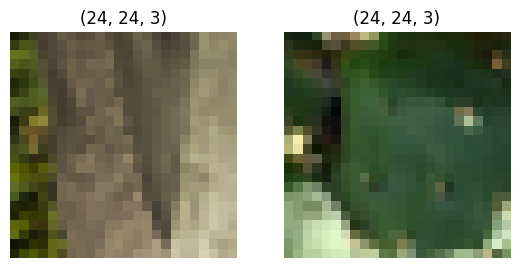

In [9]:
low_res, high_res = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(2):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(high_res[i].numpy().astype("uint8"))
  plt.title(high_res[i].shape)
  plt.axis("off")

plt.figure(figsize=(10, 10))
for i in range(2):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(low_res[i].numpy().astype("uint8"))
  plt.title(low_res[i].shape)
  plt.axis("off")

In [10]:
def PSNR(super_res, high_res):
  psnr_value = tf.image.psnr(high_res, super_res, max_val=255)[0]
  return psnr_value

In [11]:
class EDSRModel(tf.keras.Model):
  def train_step(self, data):
    x, y = data
    with tf.GradientTape() as tape:
      y_pred = self(x, training=True)
      loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    self.compiled_metrics.update_state(y, y_pred)
    return {
        m.name: m.result() for m in self.metrics
    }

  def predict_steps(self, x):
    x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
    super_resolution_img = self(x, training=False)
    super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
    super_resolution_img = tf.round(super_resolution_img)
    super_resolution_img = tf.squeeze(
        tf.cast(super_resolution_img, tf.uint8), axis=0
    )
    return super_resolution_img

In [12]:
def ResBlock(inputs):
  x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
  x = layers.Conv2D(32, 3, padding="same")(x)
  x = layers.Add()([inputs, x])
  return x

In [13]:
def UpSampling(inputs, factor=2, **kwargs):
  x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
  x = tf.nn.depth_to_space(x, block_size=factor)
  x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
  x = tf.nn.depth_to_space(x, block_size=factor)
  return x

In [14]:
def make_model(num_filters, num_residual_blocks):
  input_layer = layers.Input(shape=(None, None, 3))
  x = layers.Rescaling(scale=1.0 / 255)(input_layer)
  x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)
  for _ in range(num_residual_blocks):
    x_new = ResBlock(x_new)
  x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
  x = layers.Add()([x, x_new])
  x = UpSampling(x)
  x = layers.Conv2D(3, 3, padding="same")(x)
  output_layer = layers.Rescaling(scale=255)(x)
  return EDSRModel(input_layer, output_layer)

In [15]:
model = make_model(num_filters=32, num_residual_blocks=8)

In [16]:
optim = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000],
        values=[1e-4, 5e-5]
    )
)

In [17]:
model.compile(optimizer=optim, loss="mae", metrics=[PSNR])

In [ ]:
model.fit(
    train_ds,
    epochs=100,
    steps_per_epoch=100,
    validation_data=val_ds
)

Epoch 1/100
100/100 [==============================] - 72s 449ms/step - loss: 28.8931 - PSNR: 17.8119 - val_loss: 17.8415 - val_PSNR: 20.5482
Epoch 2/100
 45/100 [============>.................] - ETA: 18s - loss: 17.6903 - PSNR: 20.8723

In [ ]:
def plot_results(low_res, preds):
  plt.figure(figsize=(24, 14))
  plt.subplot(132), plt.imshow(low_res), plt.title("Low Resolution")
  plt.subplot(133), plt.imshow(preds), plt.title("Prediction")
  plt.show()

In [ ]:
for low_res, high_res in val.take(10):
    lowres = tf.image.random_crop(low_res, (150, 150, 3))
    preds = model.predict_step(low_res)
    plot_results(low_res, preds)